<a href="https://colab.research.google.com/github/wiah/deep-learning-project-2020/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries

## Dependencies

In [ ]:
!pip uninstall torch torchaudio fairseq -y
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fairseq
!pip install -U sentence-transformers

## Imports

In [ ]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
data_path = "./drive/MyDrive/DybLæring/"
plots_path = data_path + "plots"
import os
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(plots_path):
    os.makedirs(plots_path)
import numpy as np
import pandas as pd
import pickle
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from IPython.display import Audio
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from fairseq.utils import buffered_arange
from sentence_transformers import SentenceTransformer

# Random seed for reproducilibity. Applies to NumPy, and in turn, PyTorch
np.random.seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Import data and create subset

## IMPORTANT
Place `wav_lengths.pickle` and `wav_lengths_test.pickle` in the `DybLæring` folder created on your Google Drive.

In [ ]:
with open(data_path + 'wav_lengths.pickle', 'rb') as f:
    wav_lengths_train = pickle.load(f)
wav_lengths_train = np.array(wav_lengths_train)

with open(data_path + 'wav_lengths_test.pickle', 'rb') as f:
    wav_lengths_test = pickle.load(f)
wav_lengths_test = np.array(wav_lengths_test)

cutoff_length = 64000
train_size = 1000
test_size = 1000 # max(math.floor(train_size/5), 1) # Test size must be >= 1

full_dataset_train = torchaudio.datasets.LIBRISPEECH(data_path, url = 'train-clean-100',
                                           folder_in_archive= 'LibriSpeech', 
                                           download = True)

full_dataset_test = torchaudio.datasets.LIBRISPEECH(data_path, url = 'test-clean',
                                           folder_in_archive= 'LibriSpeech', 
                                           download = True)

# Create a subset of subset_size, with size less than cutoff_length
train_indices = np.where(wav_lengths_train < cutoff_length)[0]
test_indices = np.where(wav_lengths_test < cutoff_length)[0]

train_dataset = torch.utils.data.Subset(full_dataset_train, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset_test, test_indices)

rand_perm_train = torch.randperm(len(train_dataset))
rand_perm_test = torch.randperm(len(test_dataset))
train_indices = rand_perm_train[:train_size]
test_indices = rand_perm_test[:test_size]

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

data_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=1,
                                          shuffle=True)

data_loader_test = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1,
                                          shuffle=True)

## Sample waveform

Sample transcription: WE THINK THAT BY SOME LITTLE WORK OR MERIT WE CAN DISMISS SIN
Sample length: 63360



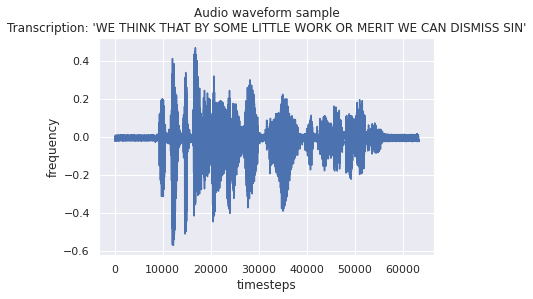

In [ ]:
sample = next(iter(data_loader_test))
waveform = sample[0][0][0]
framerate = sample[1]
print(f"Sample transcription: {sample[2][0]}")
print(f"Sample length: {len(waveform)}\n")
ax = sns.lineplot(data=waveform.t().numpy())
ax.set(xlabel='timesteps', ylabel='frequency', title=f"Audio waveform sample\nTranscription: '{sample[2][0]}'")
fig = ax.get_figure()
fig.savefig(plots_path + "/waveform_example.png") 
Audio(waveform.numpy(), rate = int(framerate.numpy()))

## Data preprocessing

In [ ]:
print(f"Specified cutoff length: {cutoff_length}\n")

def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

def preprocess(wav):
    """
    Pads to specified cutoff and normalizes wave file
    """
    pad = torch.zeros(cutoff_length)
    length = len(wav)
    # normalize
    wav = normalize(wav)
    # add padding 
    pad[:length] = wav[:min(length, cutoff_length)]
    return pad

# TEST 
test = torch.ones(300000)
pre_processed_sample = preprocess(torch.squeeze(sample[0]))
print(f"Original sample shape: {sample[0].shape}")
print(f"Shape after preprocessing: {pre_processed_sample.shape}")
print(f"Sample: {pre_processed_sample}")

In [ ]:
class LibriSpeechTriplet(torch.utils.data.Dataset):
    def __init__(self, data, with_negative=True, transform=None):
        self.data = data
        self.with_negative = with_negative
        self.transform = transform
    
    def framerate(self):
        return 16000
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        anchor = self.data[item]
        anchor_waveform = anchor[0][0]
        anchor_transcription = anchor[2]

        if self.with_negative:
            # Sample a data point different from the one requested
            negative_idx = item
            while (negative_idx == item):
                negative_idx = random.randint(0, self.__len__()-1)
            
            negative = self.data[negative_idx]
            negative_waveform = negative[0][0]
            negative_transcription = negative[2]

            if self.transform:
                anchor_waveform = self.transform(anchor_waveform)
                negative_waveform = self.transform(negative_waveform)
            
            return anchor_transcription, anchor_waveform, negative_transcription, negative_waveform
        
        else:
            if self.transform:
                anchor_waveform = self.transform(anchor_waveform)
            
            return anchor_transcription, anchor_waveform

In [ ]:
train_triplet_dataset = LibriSpeechTriplet(train_dataset, with_negative=False, transform=preprocess)
test_triplet_dataset = LibriSpeechTriplet(test_dataset, with_negative=False, transform=preprocess)

train_loader = torch.utils.data.DataLoader(train_triplet_dataset,
                                                  batch_size=20,
                                                  shuffle=True)

test_loader = torch.utils.data.DataLoader(test_triplet_dataset,
                                                  batch_size=20,
                                                  shuffle=False)

test_transcription, test_waveform = next(iter(train_loader))

## Encoder Network

In [ ]:
def norm_block(dim, affine=True):
  return nn.BatchNorm1d(dim)

class wav2vec2_Embedder(nn.Module):
    def __init__(self):
        super(wav2vec2_Embedder, self).__init__()
        channels = 512
        input_size = 1
        output_size = 512
        kernel_sizes = [10, 3, 3, 3, 3, 2, 2,]
        stride_sizes = [5 , 2, 2, 2, 2, 2, 2,]
        
        self.conv1 = nn.Conv1d(1, channels, 
                               kernel_size=kernel_sizes[0], 
                               stride=stride_sizes[0])
        
        self.conv2 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[1],  
                               stride=stride_sizes[1])

        self.conv3 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[2],  
                               stride=stride_sizes[2])

        self.conv4 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[3],  
                               stride=stride_sizes[3])

        self.conv5 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[4],  
                               stride=stride_sizes[4])

        self.conv6 = nn.Conv1d(channels, output_size, 
                               kernel_size=kernel_sizes[5],  
                               stride=stride_sizes[5])
        
        self.conv7 = nn.Conv1d(channels, output_size, 
                               kernel_size=kernel_sizes[6],  
                               stride=stride_sizes[6])

        self.LN = norm_block(channels) 
        self.GELU = nn.GELU()
        self.dropout = nn.Dropout()
        
    def forward(self, input):
        z_t = self.conv1(input.unsqueeze(1))
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)
        z_t = self.dropout(z_t)

        z_t = self.conv2(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv3(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv4(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv5(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv6(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv7(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        return z_t

Embedding_net = wav2vec2_Embedder()
z_t =  Embedding_net(test_waveform)
#test: 
print(Embedding_net)
print(z_t.shape)
print(test_waveform.shape)

## sequence embedding 

In [ ]:
class wav2vec_Aggregator(nn.Module):
    def __init__(self):
        super(wav2vec_Aggregator, self).__init__()
        channels = 512
        input_size = 512
        output_size = 512
        kernel_sizes = [3,3,3,3,3,3,3,3,3]
        stride_sizes = [1,1,1,1,1,1,1,1,1]
        
        self.conv1 = nn.Conv1d(input_size, channels, 
                               kernel_size=kernel_sizes[0], 
                               stride=stride_sizes[0],
                               padding = 1)
        
        self.conv2 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[1],  
                               stride=stride_sizes[1],
                               padding = 1)

        self.conv3 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[2],  
                               stride=stride_sizes[2],
                               padding = 1)

        self.conv4 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[3],  
                               stride=stride_sizes[3],
                               padding = 1)

        self.conv5 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[4],  
                               stride=stride_sizes[4],
                               padding = 1)

        self.conv6 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[5],  
                               stride=stride_sizes[5],
                               padding = 1)

        self.conv7 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[6],  
                               stride=stride_sizes[6],
                               padding = 1)
        self.conv8 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[7],  
                               stride=stride_sizes[7],
                               padding = 1)
        self.conv9 = nn.Conv1d(channels, output_size, 
                               kernel_size=kernel_sizes[8],  
                               stride=stride_sizes[8],
                               padding = 1)

        self.LN = norm_block(channels) 
        self.GELU = nn.GELU()
        self.dropout = nn.Dropout()
        
    def forward(self, input):
        z_t = self.conv1(input)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv2(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)
        
        z_t = self.dropout(z_t)
        z_t = self.conv3(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv4(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv5(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv6(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv7(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv8(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv9(z_t)
        c_t = self.GELU(z_t)

        return c_t

Aggregator_net = wav2vec_Aggregator()
print(Aggregator_net)
#test: 
c_t = Aggregator_net(z_t)
print(c_t)
print(c_t.shape)

# Prediction layer
## This layer is needed to train the wav2vec model.

In [ ]:
# The prediction models are partially adapted from the code from this repository:
# https://github.com/pytorch/fairseq/blob/master/fairseq/models/wav2vec/wav2vec.py

class TripletArticlePredictionsModel(nn.Module):
    def __init__(
        self,
        in_dim,
        out_dim,
        prediction_steps,
        n_negatives,
        cross_sample_negatives,
        sample_distance,
        dropout,
        offset,
        balanced_classes,
    ):
        super().__init__()

        self.n_negatives = n_negatives
        self.cross_sample_negatives = cross_sample_negatives
        self.sample_distance = sample_distance
        self.project_to_text = nn.Conv1d(in_dim, out_dim, 
                               kernel_size=3,  
                               stride=1,
                               padding = 1)
        self.dropout = nn.Dropout(p=dropout)
        self.offset = offset
        self.balanced_classes = balanced_classes
        self.sigmoid = nn.Sigmoid()

    def sample_negatives(self, z_t):
        bsz, fsz, tsz = z_t.shape

        z_t = z_t.transpose(0, 1)  # BCT -> CBT
        z_t = z_t.contiguous().view(fsz, -1)  # CBT => C(BxT)

        cross_high = tsz * bsz
        high = tsz if self.sample_distance is None else min(tsz, self.sample_distance)
        assert high > 1

        neg_idxs = torch.randint(low=0, high=high, size=(bsz, self.n_negatives * tsz))

        with torch.no_grad():
            if self.n_negatives > 0:
                tszs = (
                    buffered_arange(tsz)
                    .unsqueeze(-1)
                    .expand(-1, self.n_negatives)
                    .flatten()
                )

                neg_idxs = torch.randint(
                    low=0, high=high - 1, size=(bsz, self.n_negatives * tsz)
                )
                neg_idxs[neg_idxs >= tszs] += 1

            if self.cross_sample_negatives > 0:
                tszs = (
                    buffered_arange(tsz)
                    .unsqueeze(-1)
                    .expand(-1, self.cross_sample_negatives)
                    .flatten()
                )

                cross_neg_idxs = torch.randint(
                    low=0,
                    high=cross_high - 1,
                    size=(bsz, self.cross_sample_negatives * tsz),
                )
                cross_neg_idxs[cross_neg_idxs >= tszs] += 1

        if self.n_negatives > 0:
            for i in range(1, bsz):
                neg_idxs[i] += i * high
        else:
            neg_idxs = cross_neg_idxs

        if self.cross_sample_negatives > 0 and self.n_negatives > 0:
            neg_idxs = torch.cat([neg_idxs, cross_neg_idxs], dim=1)

        negs = z_t[..., neg_idxs.view(-1)]
        negs = negs.view(
            fsz, bsz, self.n_negatives + self.cross_sample_negatives, tsz
        ).permute(
            2, 1, 0, 3
        )  # to NxBxCxT

        return negs

    def forward(self, c_t, text):
         
        

        text_neg = self.sample_negatives(text)
        text_neg = text_neg.squeeze(0)
        c_t = self.project_to_text(c_t)

        # transform to N,D for triplet loss input shape
        c_t = torch.reshape(c_t,(-1,768 ))
        text = torch.reshape(text,(-1, 768))
        text_neg = torch.reshape(text_neg,(-1, 768))

        

        return  c_t, text, text_neg

class Wav2VecPredictionsModel(nn.Module):
    def __init__(
        self,
        in_dim,
        out_dim,
        prediction_steps,
        n_negatives,
        cross_sample_negatives,
        sample_distance,
        dropout,
        offset,
        balanced_classes,
    ):
        super().__init__()

        self.n_negatives = n_negatives
        self.cross_sample_negatives = cross_sample_negatives
        self.sample_distance = sample_distance
        self.project_to_steps = nn.ConvTranspose2d(
            in_dim, out_dim, (1, prediction_steps)
        )
        self.dropout = nn.Dropout(p=dropout)
        self.offset = offset
        self.balanced_classes = balanced_classes
        self.sigmoid = nn.Sigmoid()

    def sample_negatives(self, z_t):
        bsz, fsz, tsz = z_t.shape

        z_t = z_t.transpose(0, 1)  # BCT -> CBT
        z_t = z_t.contiguous().view(fsz, -1)  # CBT => C(BxT)

        cross_high = tsz * bsz
        high = tsz if self.sample_distance is None else min(tsz, self.sample_distance)
        assert high > 1

        neg_idxs = torch.randint(low=0, high=high, size=(bsz, self.n_negatives * tsz))

        with torch.no_grad():
            if self.n_negatives > 0:
                tszs = (
                    buffered_arange(tsz)
                    .unsqueeze(-1)
                    .expand(-1, self.n_negatives)
                    .flatten()
                )

                neg_idxs = torch.randint(
                    low=0, high=high - 1, size=(bsz, self.n_negatives * tsz)
                )
                neg_idxs[neg_idxs >= tszs] += 1

            if self.cross_sample_negatives > 0:
                tszs = (
                    buffered_arange(tsz)
                    .unsqueeze(-1)
                    .expand(-1, self.cross_sample_negatives)
                    .flatten()
                )

                cross_neg_idxs = torch.randint(
                    low=0,
                    high=cross_high - 1,
                    size=(bsz, self.cross_sample_negatives * tsz),
                )
                cross_neg_idxs[cross_neg_idxs >= tszs] += 1

        if self.n_negatives > 0:
            for i in range(1, bsz):
                neg_idxs[i] += i * high
        else:
            neg_idxs = cross_neg_idxs

        if self.cross_sample_negatives > 0 and self.n_negatives > 0:
            neg_idxs = torch.cat([neg_idxs, cross_neg_idxs], dim=1)

        negs = z_t[..., neg_idxs.view(-1)]
        negs = negs.view(
            fsz, bsz, self.n_negatives + self.cross_sample_negatives, tsz
        ).permute(
            2, 1, 0, 3
        )  # to NxBxCxT

        return negs

    def forward(self, c_t, z_t):
        
        c_t = c_t.unsqueeze(-1)
        c_t = self.project_to_steps(c_t)  # BxCxTxS
        c_t = self.dropout(c_t)


        negatives = self.sample_negatives(z_t)
        
        z_t = z_t.unsqueeze(0)
        targets = torch.cat([z_t, negatives], dim=0)  # Copies x B x C x T
        copies = targets.size(0)
        bsz, dim, tsz, steps = c_t.shape
        steps = min(steps, tsz - self.offset)

        predictions = c_t.new(
            bsz * copies * (tsz - self.offset + 1) * steps
            - ((steps + 1) * steps // 2) * copies * bsz
        )

        labels = torch.zeros_like(predictions)
        weights = (
            torch.full_like(labels, 1 / self.n_negatives))

        start = end = 0
        for i in range(steps):
            offset = i + self.offset
            end = start + (tsz - offset) * bsz * copies

            pos_num = (end - start) // copies
            predictions[start:end] = torch.einsum(
                    "bct,nbct->nbt", c_t[..., :-offset, i], targets[..., offset:]
                ).flatten()

            labels[start : start + pos_num] = 1.0
            weights[start : start + pos_num] = 1.0
            start = end

      
        labels = (labels, weights)

        return predictions, labels



class TripletPredictionsModel(nn.Module):
    def __init__(
        self,
        in_dim,
        out_dim,
        prediction_steps,
        n_negatives,
        cross_sample_negatives,
        sample_distance,
        dropout,
        offset,
        balanced_classes,
    ):
        super().__init__()

        self.n_negatives = n_negatives
        self.cross_sample_negatives = cross_sample_negatives
        self.sample_distance = sample_distance
        self.project_to_steps = nn.ConvTranspose2d(
            in_dim, out_dim, (1, prediction_steps)
        )
        self.dropout = nn.Dropout(p=dropout)
        self.offset = offset
        self.balanced_classes = balanced_classes
        self.sigmoid = nn.Sigmoid()

    def sample_negatives(self, z_t):
        bsz, fsz, tsz = z_t.shape

        z_t = z_t.transpose(0, 1)  # BCT -> CBT
        z_t = z_t.contiguous().view(fsz, -1)  # CBT => C(BxT)

        cross_high = tsz * bsz
        high = tsz if self.sample_distance is None else min(tsz, self.sample_distance)
        assert high > 1

        neg_idxs = torch.randint(low=0, high=high, size=(bsz, self.n_negatives * tsz))

        with torch.no_grad():
            if self.n_negatives > 0:
                tszs = (
                    buffered_arange(tsz)
                    .unsqueeze(-1)
                    .expand(-1, self.n_negatives)
                    .flatten()
                )

                neg_idxs = torch.randint(
                    low=0, high=high - 1, size=(bsz, self.n_negatives * tsz)
                )
                neg_idxs[neg_idxs >= tszs] += 1

            if self.cross_sample_negatives > 0:
                tszs = (
                    buffered_arange(tsz)
                    .unsqueeze(-1)
                    .expand(-1, self.cross_sample_negatives)
                    .flatten()
                )

                cross_neg_idxs = torch.randint(
                    low=0,
                    high=cross_high - 1,
                    size=(bsz, self.cross_sample_negatives * tsz),
                )
                cross_neg_idxs[cross_neg_idxs >= tszs] += 1

        if self.n_negatives > 0:
            for i in range(1, bsz):
                neg_idxs[i] += i * high
        else:
            neg_idxs = cross_neg_idxs

        if self.cross_sample_negatives > 0 and self.n_negatives > 0:
            neg_idxs = torch.cat([neg_idxs, cross_neg_idxs], dim=1)

        negs = z_t[..., neg_idxs.view(-1)]
        negs = negs.view(
            fsz, bsz, self.n_negatives + self.cross_sample_negatives, tsz
        ).permute(
            2, 1, 0, 3
        )  # to NxBxCxT

        return negs

    def forward(self, c_t, z_t):

        z_neg = self.sample_negatives(z_t)
        z_neg = z_neg.squeeze(0)

        # transform to N,D for triplet loss input shape
        c_t = torch.reshape(c_t,(-1, 512))
        z_t = torch.reshape(z_t,(-1, 512))
        z_neg = torch.reshape(z_neg,(-1, 512))

        return  c_t, z_t, z_neg


################################################################################
################################### wav2vec ######## ###########################
################################################################################
        
# setup of layer
in_dim = 512
out_dim = 512
prediction_steps = 10
n_negatives = 10
cross_sample_negatives = 0
sample_distance = None
dropout = 0.4
offset = 1
balanced_classes = True

prediction_net_wav2vec = Wav2VecPredictionsModel(in_dim, out_dim,
                                         prediction_steps,
                                          n_negatives, 
                                         cross_sample_negatives,
                                         sample_distance,
                                         dropout, offset,
                                         balanced_classes)

################################################################################
################################### Triplet loss ###############################
################################################################################
        
# setup of layer
in_dim = 512
out_dim = 512
prediction_steps = 10
n_negatives = 1
cross_sample_negatives = 0
sample_distance = None
dropout = 0.4
offset = 1
balanced_classes = True

prediction_net_triplet = TripletPredictionsModel(in_dim, out_dim,
                                         prediction_steps,
                                          n_negatives, 
                                         cross_sample_negatives,
                                         sample_distance,
                                         dropout, offset,
                                         balanced_classes)

#test: 
res = prediction_net_triplet(c_t,z_t)

########################################## TRIPLET LOSS WITH Text inputs #######
################################################################################



# setup of layer
in_dim = 512
out_dim = 768
prediction_steps = 10
n_negatives = 1
cross_sample_negatives = 0
sample_distance = None
dropout = 0.4
offset = 1
balanced_classes = True

prediction_net_triplet_text = TripletArticlePredictionsModel(in_dim, out_dim,
                                         prediction_steps,
                                          n_negatives, 
                                         cross_sample_negatives,
                                         sample_distance,
                                         dropout, offset,
                                         balanced_classes)
text_embedder = SentenceTransformer('bert-base-nli-mean-tokens')
test = text_embedder.encode(test_transcription)
test_transcription_vec = torch.stack([torch.Tensor(test)for i in range(z_t.shape[2])])
res = prediction_net_triplet_text(c_t,test_transcription_vec)


In [ ]:
class WavNet_wav2vec(nn.Module):
    def __init__(self, embedding_net, aggregator_net, predictor_net):
        super(WavNet_wav2vec, self).__init__()
        self.embedding  =  embedding_net
        self.aggregator =  aggregator_net
        self.predictor  =  predictor_net

        
    def forward(self, data):
        z_t = self.embedding(data)
        c_t = self.aggregator(z_t)
        preds, target_and_weights = self.predictor(c_t,z_t) 
        targets, weights = target_and_weights
        return preds, targets , weights, c_t, z_t

class WavNet_triplet(nn.Module):
    def __init__(self, embedding_net, aggregator_net, predictor_net):
        super(WavNet_triplet, self).__init__()
        self.embedding  =  embedding_net
        self.aggregator =  aggregator_net
        self.predictor  =  predictor_net

        
    def forward(self, data):
        z_t = self.embedding(data)

        c_t = self.aggregator(z_t)
        c_t, z_t,  z_neg = self.predictor(c_t,z_t) 
        return  c_t, z_t,  z_neg

class WavNet_triplet_article(nn.Module):
    def __init__(self, embedding_net, aggregator_net, predictor_net):
        super(WavNet_triplet_article, self).__init__()
        self.embedding  =  embedding_net
        self.aggregator =  aggregator_net
        self.predictor  =  predictor_net

        
    def forward(self, data,text):
        z_t = self.embedding(data)

        c_t = self.aggregator(z_t)
        c_t, text, text_neg = self.predictor(c_t,text) 
        return c_t, text, text_neg


## Choose which model to train

In [ ]:
model_names = ['wav2vec', 'triplet', 'triplet_article']
selected_model = model_names[2]

In [ ]:
if selected_model == model_names[0]: # wav2vec
  wavNet = WavNet_wav2vec(Embedding_net,Aggregator_net, prediction_net_wav2vec)
  criterion = F.binary_cross_entropy_with_logits
if selected_model == model_names[1]: # triplet
  wavNet = WavNet_triplet(Embedding_net,Aggregator_net, prediction_net_triplet)
  criterion = nn.TripletMarginLoss(margin=0.00001)
if selected_model == model_names[2]: # triplet article
  wavNet = WavNet_triplet_article(Embedding_net, Aggregator_net, prediction_net_triplet_text)
  criterion = nn.TripletMarginLoss(margin=0.00001)
wavNet.to(device)



# Text to vec



## Other hyper parameters 

In [ ]:
optimizer = optim.Adam(wavNet.parameters(), lr = 0.0001, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.5)

In [ ]:
def print_training_stats(epoch, epochs, batch_idx, batch_size, dataset_size, loss):
    print('Epoch: {:>4d}/{:<4d}[{:>6d}/{} ({:4.1f}%)]\tLoss: {:.4f}'.format(
        epoch,
        epochs,
        batch_idx * batch_size, 
        dataset_size,
        100. * batch_idx * batch_size / dataset_size, 
        loss))

In [ ]:
train_losses, test_losses = [], []
log_interval = 1
epochs = 100

def train(model, epoch):
    model.train()
    batch_losses = []
    for batch_idx, (pos_text, pos_wav) in enumerate(train_loader):

        pos_wav = pos_wav.to(device)
        optimizer.zero_grad()

        # wav2vec
        if selected_model == model_names[0]: 
            preds, targets , weights, c_t, z_t = model(pos_wav)
            loss = criterion(
                preds,
                targets.float(),
                weights,
                reduction="sum" 
            )

        # Triplet
        if selected_model == model_names[1]:
            c_t, z_t,  z_neg = model(pos_wav)
            loss = criterion( c_t, z_t,  z_neg)
        
        # Triplet article
        if selected_model == model_names[2]:
            pos_text = text_embedder.encode(pos_text, show_progress_bar = False)
            pos_text = torch.stack([torch.Tensor(pos_text)for i in range(199)])
            pos_text = pos_text.to(device)
            c_t, text, text_neg = model(pos_wav,pos_text)
            loss = criterion(c_t, text, text_neg)
        
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print_training_stats(epoch, epochs, batch_idx, len(pos_wav), len(train_triplet_dataset), loss.item())

    mean_loss = np.mean(batch_losses)
    train_losses.append(mean_loss)

    print(f"Training epoch {epoch} finished. Avg. epoch loss: {mean_loss:.6f}")
    


def test(model, epoch):
    print("Testing model... ", end='')
    
    with torch.no_grad():
      model.eval()
      correct = 0
      batch_losses = []
      for batch_idx, (pos_text, pos_wav) in enumerate(test_loader):
          pos_wav = pos_wav.to(device)
          
          # wav2vec
          if selected_model == model_names[0]: 
              preds, targets , weights, c_t, z_t = model(pos_wav)
              loss = criterion(
                  preds,
                  targets.float(),
                  weights,
                  reduction="sum" 
              )

          # Triplet
          if selected_model == model_names[1]:
              c_t, z_t,  z_neg = model(pos_wav)
              loss = criterion( c_t, z_t,  z_neg)
          
          # Triplet article
          if selected_model == model_names[2]:
              pos_text = text_embedder.encode(pos_text, show_progress_bar = False)
              pos_text = torch.stack([torch.Tensor(pos_text)for i in range(199)])
              pos_text = pos_text.to(device)
              c_t, text, text_neg = model(pos_wav,pos_text)
              loss = criterion(c_t, text, text_neg)
          
          batch_losses.append(loss.item())

      mean_loss = np.mean(batch_losses)
      test_losses.append(mean_loss)

      print(f"Epoch {epoch} test loss: {mean_loss:.6f}")

# Training/test loop
for epoch in range(1, epochs):
    train(wavNet, epoch)
    test(wavNet, epoch)
    scheduler.step()

## Plot losses

In [ ]:
ax = sns.lineplot(data=[train_losses, test_losses])
ax.set(xlabel='Epoch', ylabel='Loss', title=f"{selected_model} loss evolution")
for t, l in zip(ax.get_legend().texts, ['train', 'test']): t.set_text(l)
fig = ax.get_figure()

# Finetuning




##Char Embedding

In [ ]:
# Transforms a string into a list of ints, where each char is an int
# Insipired by: https://github.com/LearnedVector/Wav2Letter/blob/master/Wav2Letter/data.py?fbclid=IwAR3EEKsY2QmKF1v9b6pUxmPBtZnpz4X2M_ythi9hQYOxuHHzTZKVRwP9pHQ

pad_strings = 100
class IntegerEncode:
    """Encodes labels into integers
    
    Args:
        labels (list): shape (n_samples, strings)
    """

    def __init__(self, labels):
        # reserve 0 for blank label
        self.char2index = {
            "-": 0,
            "pad":1
        }
        self.index2char = {
            0: "-",
            1: "pad"
        }
        self.grapheme_count = 2
        self.process(labels)
        self.max_label_seq = pad_strings

    def process(self, labels):
        """builds the encoding values for labels
        
        Args:
            labels (list): shape (n_samples, strings)
        """
        strings = "".join(labels)
        for s in strings:
            if s not in self.char2index:
                self.char2index[s] = self.grapheme_count
                self.index2char[self.grapheme_count] = s
                self.grapheme_count += 1

    def convert_to_ints(self, label):
        """Convert into integers
        
        Args:
            label (str): string to encode
        
        Returns:
            list: shape (max_label_seq)
        """
        y = []
        for char in label:
            y.append(self.char2index[char])
        y_len = len(y)
        if len(y) < self.max_label_seq:
            diff = self.max_label_seq - len(y)
            pads = [self.char2index["pad"]] * diff
            y += pads
        #y = y[:self.max_label_seq]
        return (torch.IntTensor(y), y_len)
    
    def convert_to_chars(self, label):
      y = []
      for integer in label:
        y.append(self.index2char[integer])
      return y

    def save(self, file_path):
        """Save integer encoder model as a pickle file
        Args:
            file_path (str): path to save pickle object
        """
        file_name = os.path.join(file_path, "int_encoder.pkl")
        with open(file_name, 'wb') as f:
            pickle.dump(self.__dict__, f)


tekst_encoder = IntegerEncode(" QWERTYUIOPLKJHGFDSAZXCVBNM'")
test = [tekst_encoder.convert_to_ints(text)[0] for text in test_transcription] 
test = torch.stack(test)
print(test.shape)
[tekst_encoder.convert_to_ints(text)[1] for text in test_transcription]

## Baseline Model
### simple Wav2Letter architecture

In [ ]:
class Wav2Letter(nn.Module):
    """Wav2Letter Speech Recognition model
        Architecture is based off of Facebooks AI Research paper
        https://arxiv.org/pdf/1609.03193.pdf
        This specific architecture accepts mfcc or
        power spectrums speech signals
        Args:
            num_features (int): number of mfcc features
            num_classes (int): number of unique grapheme class labels
    """

    def __init__(self):
        super(Wav2Letter, self).__init__()
        channels = 512
        input_size = 1
        output_size = tekst_encoder.grapheme_count
        kernel_sizes = [10,3,3,3,3,2,2]
        stride_sizes = [5 ,2,2,2,2,2,2]
        
        self.conv1 = nn.Conv1d(1, channels, 
                               kernel_size=kernel_sizes[0], 
                               stride=stride_sizes[0])
        
        self.conv2 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[1],  
                               stride=stride_sizes[1])

        self.conv3 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[2],  
                               stride=stride_sizes[2])

        self.conv4 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[3],  
                               stride=stride_sizes[3])

        self.conv5 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[4],  
                               stride=stride_sizes[4])

        self.conv6 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[5],  
                               stride=stride_sizes[5])

        self.conv7 = nn.Conv1d(channels, output_size, 
                               kernel_size=kernel_sizes[6],  
                               stride=stride_sizes[6])

        self.LN = norm_block(channels) 
        self.GELU = nn.GELU()
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input):
        z_t = self.conv1(input.unsqueeze(1))
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)
        z_t = self.dropout(z_t)

        z_t = self.conv2(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv3(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv4(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv5(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv6(z_t)
        z_t = self.GELU(z_t)
        z_t = self.LN(z_t)

        z_t = self.dropout(z_t)
        z_t = self.conv7(z_t)
        

        # compute log softmax probability on graphemes
        output = self.softmax(z_t)

        return output.transpose(1, 2).transpose(0, 1)



## Modified Wav2Letter.
### Combine Embeddings with modified Wav2Letter architecture


In [ ]:
Inchannels = 512
Outchannels = tekst_encoder.grapheme_count
elems = 812
from torch import topk
class vec_to_char(nn.Module):
    def __init__(self,wavNet):
        super(vec_to_char, self).__init__()
        channels = 512

        input_size = 512
        output_size = tekst_encoder.grapheme_count
        kernel_sizes = [3,3,3,3,3,3,3,3,3]
        stride_sizes = [1,1,1,1,1,1,1,1,1]
        
        self.wavNet = wavNet

        self.conv1 = nn.Conv1d(input_size, channels, 
                               kernel_size=kernel_sizes[0], 
                               stride=stride_sizes[0],
                               padding = 1)
        
        self.conv2 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[1],  
                               stride=stride_sizes[1],
                               padding = 1)

        self.conv3 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[2],  
                               stride=stride_sizes[2],
                               padding = 1)

        self.conv4 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[3],  
                               stride=stride_sizes[3],
                               padding = 1)

        self.conv5 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[4],  
                               stride=stride_sizes[4],
                               padding = 1)

        self.conv6 = nn.Conv1d(channels, channels, 
                               kernel_size=kernel_sizes[5],  
                               stride=stride_sizes[5],
                               padding = 1)

        self.conv7 = nn.Conv1d(channels, output_size, 
                               kernel_size=kernel_sizes[6],  
                               stride=stride_sizes[6],
                               padding = 1)

        self.LN = norm_block(channels) 
        self.GELU = nn.GELU()
        self.dropout = nn.Dropout( p=0.1)
    
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, data):
        self.wavNet.eval() #<-- WE SHOULD NOT TRAIN THE NETWORK
        z_t = self.wavNet.embedding(data)
        c_t = self.wavNet.aggregator(z_t) # So we do not need text to generate 
                                          # some embeddings
        c_t = self.LN(c_t)
        c_t = self.conv1(c_t)
        c_t = self.GELU(c_t)
        c_t = self.LN(c_t)

        c_t = self.dropout(c_t)
        c_t = self.conv2(c_t)
        c_t = self.GELU(c_t)
        c_t = self.LN(c_t)
        
        c_t = self.dropout(c_t)
        c_t = self.conv3(c_t)
        c_t = self.GELU(c_t)
        c_t = self.LN(z_t)

        c_t = self.dropout(c_t)
        c_t = self.conv4(c_t)
        c_t = self.GELU(c_t)
        c_t = self.LN(c_t)

        c_t = self.dropout(c_t)
        c_t = self.conv5(c_t)
        c_t = self.GELU(c_t)
        c_t = self.LN(c_t)

        c_t = self.dropout(c_t)
        c_t = self.conv6(c_t)
        c_t = self.GELU(c_t)
        c_t = self.LN(c_t)

        c_t = self.dropout(c_t)
        c_t = self.conv7(c_t)
        

        output = self.softmax(c_t)
        
  
      
        # CTC_Loss expects input shape
        # (input_length, batch_size, num_classes)
        return output.transpose(1, 2).transpose(0, 1)
        


## DECODER

In [ ]:
from torch import topk

def GreedyDecoder(ctc_matrix, blank_label=0):
    """Greedy Decoder. Returns highest probability of
        class labels for each timestep
        # TODO: collapse blank labels
    Args:
        ctc_matrix (torch.Tensor): 
            shape (1, num_classes, output_len)
        blank_label (int): blank labels to collapse
    
    Returns:
        torch.Tensor: class labels per time step.
         shape (ctc timesteps)
    """
    output = topk(ctc_matrix, k=1, dim=2)[1]
    output = output.squeeze(2).T
    output =  ["".join(tekst_encoder.convert_to_chars(text.cpu().numpy())) for text in output] 

    return output

In [ ]:
#Baseline model
run_baseline = False

if run_baseline:
  	wav_to_char = Wav2Letter()
else:
    wav_to_char = vec_to_char(wavNet)

# GET TO DA GPU !!
wav_to_char.to(device)

# TEST MODEL
test =  wav_to_char(test_waveform.to(device))
print(test.shape)

## Training

In [ ]:
criterion = nn.CTCLoss(zero_infinity=True,reduction="mean")

optimizer = optim.Adam(wavNet.parameters(), lr = 0.001, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)
train_losses, test_losses = [], []

In [ ]:
# https://github.com/LearnedVector/Wav2Letter/blob/master/train.py
log_interval = 1
epochs = 50

def train(model, epoch):
    model.train()
    batch_losses = []
    for batch_idx, (pos_text, pos_wav) in enumerate(train_loader):
        optimizer.zero_grad()

        # Input:
        output = model(pos_wav.to(device))
        # output:
        target_lengths = torch.IntTensor([tekst_encoder.convert_to_ints(text)[1] for text in pos_text])
        pos_text = [tekst_encoder.convert_to_ints(text)[0] for text in pos_text]
        pos_text = torch.stack(pos_text)

        # length of input and output 
        mini_batch_size = len(pos_wav)
        input_lengths = torch.full((mini_batch_size,), output.shape[0], dtype=torch.long)

        
        loss = criterion(output,pos_text, input_lengths, target_lengths)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print_training_stats(epoch, epochs, batch_idx, len(pos_wav), len(train_triplet_dataset), loss.item())

    mean_loss = np.mean(batch_losses)
    train_losses.append(mean_loss)

    print(f"Training epoch {epoch} finished. Avg. epoch loss: {mean_loss:.6f}")

def test(model, epoch):
    print("Testing model... ", end='')
    
    with torch.no_grad():
      model.eval()
      correct = 0
      batch_losses = []
      for batch_idx, (pos_text, pos_wav) in enumerate(test_loader):
        # Input:
        output = model(pos_wav.to(device))
        
        # output:
        target_lengths = torch.IntTensor([tekst_encoder.convert_to_ints(text)[1] for text in pos_text])
        pos_text = [tekst_encoder.convert_to_ints(text)[0] for text in pos_text]
        pos_text = torch.stack(pos_text)

        # length of input and output 
        mini_batch_size = len(pos_wav)
        input_lengths = torch.full((mini_batch_size,), output.shape[0], dtype=torch.long)

        loss = criterion(output,pos_text, input_lengths, target_lengths)
        batch_losses.append(loss.item())
    
      mean_loss = np.mean(batch_losses)
      test_losses.append(mean_loss)

      print(f"Epoch {epoch} test loss: {mean_loss:.6f}")


# Train loop
for epoch in range(1, epochs):
    train(wav_to_char, epoch)
    test(wav_to_char, epoch)
    scheduler.step()

In [ ]:
ax = sns.lineplot(data=[train_losses[:50], test_losses[:50]])
ax.set(xlabel='Epoch', ylabel='Loss', title=f"{'CTC baseline' if run_baseline else selected_model} loss evolution")
for t, l in zip(ax.get_legend().texts, ['train', 'test']): t.set_text(l)

## CTC FINAL losses

 

In [ ]:
with open(data_path + 'CTC_baseline_model_train_loss.pickle', 'rb') as f:
  baseline_train = pickle.load(f)
with open(data_path + 'CTC_baseline_model_test_loss.pickle', 'rb') as f:
  baseline_test = pickle.load(f)

with open(data_path + 'CTC_wav2vec_train_loss.pickle', 'rb') as f:
  wav2vec_train = pickle.load(f)
with open(data_path + 'CTC_wav2vec_test_loss.pickle', 'rb') as f:
  wav2vec_test = pickle.load(f)

with open(data_path + 'CTC_triplet_train_loss.pickle', 'rb') as f:
  triplet_train =  pickle.load(f)
with open(data_path + 'CTC_triplet_test_loss.pickle', 'rb') as f:
  triplet_test = pickle.load(f)


with open(data_path + 'CTC_triplet_article_train_loss.pickle', 'rb') as f:
  triplet_article_train = pickle.load(f)
with open(data_path + 'CTC_triplet_test_article_loss.pickle', 'rb') as f:
  triplet_article_test = pickle.load(f)

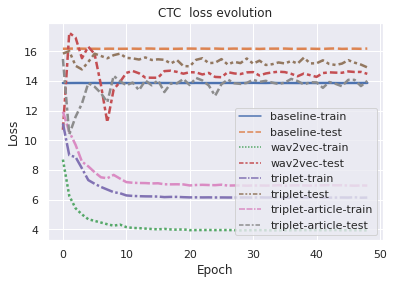

In [ ]:
ax = sns.lineplot(linewidth = 2.5, data=[baseline_train[:50], baseline_test[:50], 
                        wav2vec_train, wav2vec_test, 
                        triplet_train ,triplet_test,
                        triplet_article_train,triplet_article_test])
ax.set(xlabel='Epoch', ylabel='Loss', title=f"CTC  loss evolution")
for t, l in zip(ax.get_legend().texts, ['baseline-train', 'baseline-test',
                                        "wav2vec-train", "wav2vec-test", 
                                        "triplet-train" ,"triplet-test",
                                        "triplet-article-train","triplet-article-test"
                                        ]): t.set_text(l)
fig = ax.get_figure()
#plt.ylim(top=0.0011, bottom=-0.0001)
fig.savefig(plots_path + "/CTC_ALL_Losses.png")
#fig.savefig(plots_path + "/loss_evolution_triplet.png")